In [26]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

import matplotlib.pyplot as plt

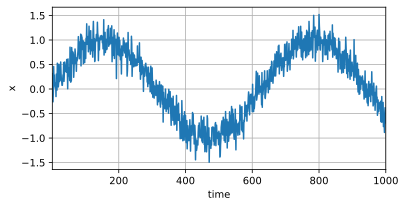

In [2]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                            batch_size, is_train=True)

print(features.shape, labels.shape)
x[:25], features[:5], labels[:5]

torch.Size([996, 4]) torch.Size([996, 1])


(tensor([ 0.2149,  0.3148, -0.2605, -0.0677,  0.4591,  0.1386,  0.2847,  0.0628,
          0.0658,  0.0205,  0.1264, -0.1531,  0.3037,  0.2031, -0.0217,  0.5259,
          0.5102,  0.3007,  0.0430,  0.1374,  0.5019,  0.1505,  0.3589,  0.1683,
          0.2874]),
 tensor([[ 0.2149,  0.3148, -0.2605, -0.0677],
         [ 0.3148, -0.2605, -0.0677,  0.4591],
         [-0.2605, -0.0677,  0.4591,  0.1386],
         [-0.0677,  0.4591,  0.1386,  0.2847],
         [ 0.4591,  0.1386,  0.2847,  0.0628]]),
 tensor([[0.4591],
         [0.1386],
         [0.2847],
         [0.0628],
         [0.0658]]))

In [15]:
print(len(labels))
print(features.shape)
i = 0
for X,y in train_iter:
    if i == 0:
        print(X.shape, y.shape)
    i += 1
print(i)

996
torch.Size([996, 4])
torch.Size([16, 4]) torch.Size([16, 1])
38


In [16]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        #print('forward: ', 'input.shape: ', input.shape, 'hidden.shape :', hidden.shape)
        input = input.reshape(1,-1)
        combined = torch.cat((input, hidden), 1)
        #print("combined.shape", combined.shape)
        hidden = self.i2h(combined)
        #print("hidden.shape", hidden.shape)
        output = self.i2o(combined)
        #print("output.shape", output.shape)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [66]:
def train(rnn, train_iter, criterion, optimizer, epochs, lr):
    running_loss = 0
    hidden = rnn.initHidden()
    rnn.zero_grad()
    losses = []

    for e in range(epochs):
        i = 0
        for X, y in train_iter:
            i += 1
            for x in X:
                output, hidden = rnn(x, hidden)

                
            output = output.detach()[0]
            print(i, ' train: output: ', output, ', y_true: ', y[-1])
            loss = criterion(output, y[-1])
            loss.backward(retain_graph=True)

            running_loss += loss.item()
            losses += [loss.item()]
            if i % 20 == 0:
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i, running_loss / 100))
                running_loss = 0.0

            # Add parameters' gradients to their values, multiplied by learning rate
            for p in rnn.parameters():
                p.data.add(p.grad.data, alpha=-learning_rate)

    
    plt.plot(losses)
    return output, loss.item()

def train2(rnn, train_iter, criterion, optimizer, epochs, lr):
    running_loss = 0
    hidden = rnn.initHidden()
    losses = []
    rnn.zero_grad()
    

    for e in range(epochs):
        i = 0
        for X, y in train_iter:
            
            i += 1
            for x in X:
                output, hidden = rnn(x, hidden)

            #output = output.detach()[0]
            print(i, ' train: output: ', output, ', y_true: ', y[-1])
            
            optimizer.zero_grad()
            loss = criterion(output, y[-1])
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses += [loss.item()]
            if i % 20 == 0:
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i, running_loss / 100))
                running_loss = 0.0

            # Add parameters' gradients to their values, multiplied by learning rate
            for p in rnn.parameters():
                p.data.add(p.grad.data, alpha=-learning_rate)

    
    plt.plot(losses)
    return output, loss.item()

In [69]:
n_hidden = 128
input_size = 4
output_size = 1

rnn1 = RNN1(input_size, n_hidden, output_size)
print(rnn1)

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(rnn1.parameters(), lr=0.001)
train(rnn1, train_iter, criterion, optimizer, 5, 0.001)

RNN1(
  (i2h): Linear(in_features=132, out_features=128, bias=True)
  (i2o): Linear(in_features=132, out_features=1, bias=True)
)
1  train: output:  tensor([0.3026]) , y_true:  tensor([0.6601])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [58]:
n_hidden = 128
input_size = 4
output_size = 1

rnn1 = RNN1(input_size, n_hidden, output_size)
print(rnn1)

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(rnn1.parameters(), lr=0.001)
train2(rnn1, train_iter, criterion, optimizer, 5, 0.001)

RNN1(
  (i2h): Linear(in_features=132, out_features=128, bias=True)
  (i2o): Linear(in_features=132, out_features=1, bias=True)
)
1  train: output:  tensor([[-0.0749]], grad_fn=<AddmmBackward>) , y_true:  tensor([0.4710])


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.

In [85]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = input_size
        #self.inp = nn.Linear(1, hidden_size) 
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, output_size) # 10 in and 10 out

    def forward(self, input, hidden):
        print("input.shape: ", input.shape, ', hidden.shape :', hidden.shape)
        input = input.reshape(1, 1, -1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    

n_hidden = 128
input_size = 4
output_size = 1

rnn2 = RNN2(input_size, n_hidden, output_size)
print(rnn2)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(rnn2.parameters(), lr=0.001)

hidden = rnn2.initHidden()
losses = []
for epoch in range(3):

    for X, y in train_iter:
        for x in X:
            output, hidden = rnn2(x, hidden)
            
        output = output.detach()[0]
        print(output, y[-1])

        optimizer.zero_grad()
        loss = criterion(output, y[-1])
        #loss.backward()
        optimizer.step()

        losses[epoch] += loss



RNN2(
  (rnn): RNN(4, 128)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([1, 1, 128])
input.shape:  torch.Size([4]) , hidden.shape : torch.Size([

RuntimeError: all elements of input should be between 0 and 1